## Stage 4 – Tuning Random Forest dengan GridSearchCV

#### Langkah 4.1 – Import & Siapkan Parameter Grid

In [2]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('../data/restaurant_profitability.csv', sep = ';')  # sesuaikan path

# Encode target
le_target = LabelEncoder()
df['Profitability'] = le_target.fit_transform(df['Profitability'])

# Pisahkan X dan y
X = df.drop(columns='Profitability')
y = df['Profitability']

# Encode fitur kategorik
le_restaurant = LabelEncoder()
le_menucategory = LabelEncoder()
le_menuitem = LabelEncoder()
le_ingredients = LabelEncoder()

X['RestaurantID'] = le_restaurant.fit_transform(X['RestaurantID'])
X['MenuCategory'] = le_menucategory.fit_transform(X['MenuCategory'])
X['MenuItem'] = le_menuitem.fit_transform(X['MenuItem'])
X['Ingredients'] = le_ingredients.fit_transform(X['Ingredients'])

# Simpan encoder agar konsisten saat deploy
import os
os.makedirs('../model', exist_ok=True)
joblib.dump(le_restaurant, '../model/le_restaurantid.pkl')
joblib.dump(le_menucategory, '../model/le_menucategory.pkl')
joblib.dump(le_menuitem, '../model/le_menuitem.pkl')
joblib.dump(le_ingredients, '../model/le_ingredients.pkl')
joblib.dump(le_target, '../model/le_target.pkl')

# Split data ke train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Buat model dasar
rf = RandomForestClassifier(random_state=42)

# Siapkan kombinasi parameter yang ingin diuji
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # penting karena label tidak seimbang
}

#### Langkah 4.2 – Grid Search CV

In [4]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Training model
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

#### Langkah 4.3 – Lihat Hasil Terbaik

In [5]:
# Parameter terbaik
print("Best Parameters:", grid_search.best_params_)

# Akurasi cross-validation terbaik
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Accuracy: 0.915


#### Langkah 4.4 – Evaluasi di Data Test

Test Accuracy: 0.925
              precision    recall  f1-score   support

         Low       0.93      0.96      0.94        77
      Medium       0.83      0.62      0.71        24
        High       0.94      0.97      0.96        99

    accuracy                           0.93       200
   macro avg       0.90      0.85      0.87       200
weighted avg       0.92      0.93      0.92       200



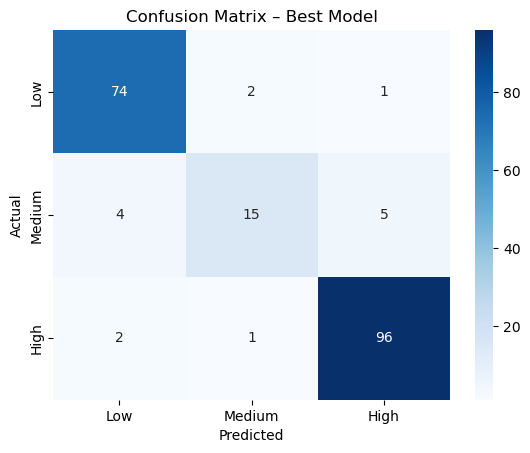

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil model terbaik
best_rf = grid_search.best_estimator_

# Prediksi test
y_pred = best_rf.predict(X_test)

# Evaluasi
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Best Model')
plt.show()


#### Langkah 4.5 – Simpan Model Terbaik

In [9]:
import joblib
import os

os.makedirs('../model', exist_ok=True)
joblib.dump(best_rf, '../model/best_model.pkl')

['../model/best_model.pkl']